In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
import os
import math

## Routine to calculate the Rotation Matrix 

In [3]:
def edge2mat(link, num_node):
    A = np.zeros((num_node, num_node))
    for i, j in link:
        A[j, i] = 1
    return A


def normalize_digraph(A):
    Dl = np.sum(A, 0)
    h, w = A.shape
    Dn = np.zeros((w, w))
    for i in range(w):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i] ** (-1)
    AD = np.dot(A, Dn)
    return AD


def get_spatial_graph(num_node, self_link, inward, outward):
    I = edge2mat(self_link, num_node)
    In = normalize_digraph(edge2mat(inward, num_node))
    Out = normalize_digraph(edge2mat(outward, num_node))
    A = np.stack((I, In, Out))
    return A

# Define the Grapsh structure . 33 joints as nodes and relation between them as edges. calcualte adjacency matrix  using spatial distance as mode

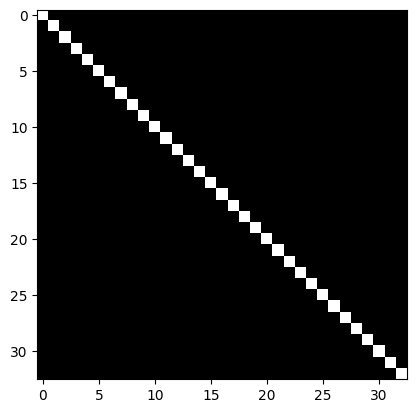

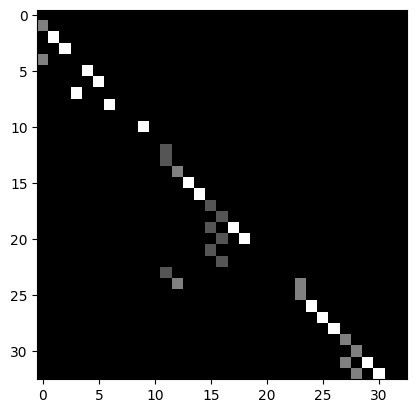

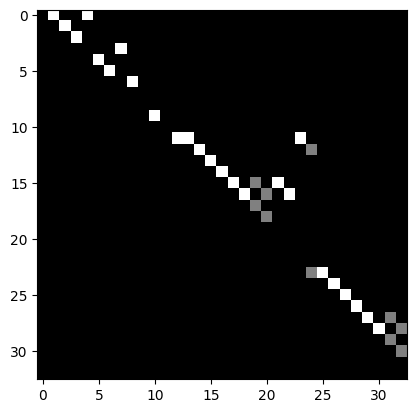

[[[1.  0.  0.  ... 0.  0.  0. ]
  [0.  1.  0.  ... 0.  0.  0. ]
  [0.  0.  1.  ... 0.  0.  0. ]
  ...
  [0.  0.  0.  ... 1.  0.  0. ]
  [0.  0.  0.  ... 0.  1.  0. ]
  [0.  0.  0.  ... 0.  0.  1. ]]

 [[0.  0.  0.  ... 0.  0.  0. ]
  [0.5 0.  0.  ... 0.  0.  0. ]
  [0.  1.  0.  ... 0.  0.  0. ]
  ...
  [0.  0.  0.  ... 0.  0.  0. ]
  [0.  0.  0.  ... 0.  0.  0. ]
  [0.  0.  0.  ... 1.  0.  0. ]]

 [[0.  1.  0.  ... 0.  0.  0. ]
  [0.  0.  1.  ... 0.  0.  0. ]
  [0.  0.  0.  ... 0.  0.  0. ]
  ...
  [0.  0.  0.  ... 0.  0.  0.5]
  [0.  0.  0.  ... 0.  0.  0. ]
  [0.  0.  0.  ... 0.  0.  0. ]]]


In [4]:
num_node = 33
self_link = [(i, i) for i in range(num_node)]
inward = [(0,1),(0,4),(1,2),(2,3),(4,5),(5,6),(3,7),(6,8),(9,10),(12,14),(14,16),(16,18),(16,20),(16,22),(18,20),
                     (11,12),(11,13),(13,15),(15,21),(15,17),(15,19),(17,19),(23,24),(12,24),(24,26),(26,28),(28,30),(28,32),(30,32),
                     (11,23),(23,25),(25,27),(27,29),(27,31),(29,31)]
outward = [(j, i) for (i, j) in inward]
neighbor = inward + outward


class Graph:
    def __init__(self, labeling_mode='spatial'):
        self.A = self.get_adjacency_matrix(labeling_mode)
        self.num_node = num_node
        self.self_link = self_link
        self.inward = inward
        self.outward = outward
        self.neighbor = neighbor

    def get_adjacency_matrix(self, labeling_mode=None):
        if labeling_mode is None:
            return self.A
        if labeling_mode == 'spatial':
            A = get_spatial_graph(num_node, self_link, inward, outward)
        else:
            raise ValueError()
        return A


if __name__ == '__main__':
    import matplotlib.pyplot as plt
    import os

    # os.environ['DISPLAY'] = 'localhost:11.0'
    A = Graph('spatial').get_adjacency_matrix()
    for i in A:
        plt.imshow(i, cmap='gray')
        plt.show()
    print(A)

In [5]:
def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    if np.abs(axis).sum() < 1e-6 or np.abs(theta) < 1e-6:
        return np.eye(3)
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])


def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)


def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    if np.abs(v1).sum() < 1e-6 or np.abs(v2).sum() < 1e-6:
        return 0
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

# routine to normalize the timeseries to have constant number of frames. in this case used 420 as frame size

In [6]:
def pre_normalization(data, zaxis=[0, 1], xaxis=[8, 4]):
    C, T, V, M = data.shape
    s = np.transpose(data, [3, 1, 2, 0])
    person=s[0]
    for i_f, frame in enumerate(person):
        if frame.sum() == 0:
                    if person[i_f:].sum() == 0:
                        rest = len(person) - i_f
                        num = int(np.ceil(rest / i_f))
                        pad = np.concatenate([person[0:i_f] for _ in range(num)], 0)[:rest]
                        s[0, i_f:] = pad
                        break
    #rhip=s[0,0,24]
    #rshoulder = s[0,0,12]
    #axis = np.cross(rhip - rshoulder, [0, 1, 0])
    #angle = angle_between(rhip - rshoulder, [0, 1, 0])
    #matrix_y = rotation_matrix(axis, angle)
    #for i_f, frame in enumerate(s[0]):
    #    for i_j, joint in enumerate(frame):
    #        s[0,i_f,i_j] = np.dot(matrix_y, joint)
    #lshoulder = s[0,0,11]
    #axis = np.cross(rshoulder - lshoulder, [1, 0, 0])
    #angle = angle_between(rshoulder - lshoulder, [1, 0, 0])
    #matrix_x = rotation_matrix(axis, angle)
    #for i_f, frame in enumerate(s[0]):
    #    for i_j, joint in enumerate(frame):
    #        s[0,i_f,i_j] = np.dot(matrix_x, joint)
    return np.transpose(s,[3,1,2,0])

In [7]:
def read_xyz(file):
    f=np.loadtxt(file, skiprows=1,delimiter=',',usecols=(range(1,100)))
    data = np.zeros((1, 420, 33, 3))
    for i in range(0,f.shape[0]):
        data[0,i,:,:]=f[i].reshape(3,33).transpose()
    return data.transpose(3, 1, 2, 0)

In [8]:
def reshape(dataset):
    n_ts = len(dataset)
    max_sz = max(
        [ts.shape[1] for ts in dataset]
    )
    d = dataset[0].shape[2]
    dataset_out = np.zeros((n_ts, 3,max_sz, d,1))
    for i in range(n_ts):
        ts = dataset[i]
        dataset_out[i, :,0: ts.shape[1],:,:] = ts
    return dataset_out

# loop thru keypoint files and create numpy array of shape no of batches , 3 (X,y,X  axis), 420 as no of frames , 33 as no of joints, 1 as no of persons in frame

In [19]:
i=0
fp=[]
y=[]
for root, dirs, files in os.walk('./Data/MediaPipe/Train'):
        for name in files:
                if(name.endswith('.csv') == False):
                    continue
                filepath = root + os.sep + name
                worktype = filepath.split(os.sep )[-2]
                filename = filepath.split(os.sep)[-1].replace('.csv','')
                if(os.path.getsize(filepath) > 0):
                    data = read_xyz(filepath)
                    data = pre_normalization(data)
                    data =data/np.linalg.norm(data)
                fp.append(data)
                y.append(worktype)


In [20]:
X= reshape(fp)
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Test Train split with shuffle to create dataset 

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [12]:
REGULARIZER = tf.keras.regularizers.l2(0.0001)
INITIALIZER = tf.keras.initializers.VarianceScaling(scale=2.,
                                                    mode="fan_out",
                                                    distribution="truncated_normal")


# Below SGCN class is for applying spatial convolution in 2D with  kernel size of 1 and apply Weight based on adjacency matrix of the graph

In [13]:
class SGCN(tf.keras.Model):
    def __init__(self, filters, kernel_size=3):
        super().__init__()
        self.kernel_size = kernel_size
        self.conv = tf.keras.layers.Conv2D(filters*kernel_size,
                                           kernel_size=1,
                                           padding='same',
                                           kernel_initializer=INITIALIZER,
                                           data_format='channels_first',
                                         kernel_regularizer=REGULARIZER)

    # N, C, T, V
    def call(self, x,A,training):
        x = self.conv(x)

        N = tf.shape(x)[0]
        C = tf.shape(x)[1]
        T = tf.shape(x)[2]
        V = tf.shape(x)[3]

        x = tf.reshape(x, [N, self.kernel_size, C//self.kernel_size, T, V])
        x = tf.einsum('nkctv,kvw->nctw', x, A)
        return x, A

# Below STGCN applies the temporal convolution with kernal size of [9,1] 

In [14]:
class STGCN(tf.keras.Model):
    def __init__(self, filters, kernel_size=[9, 3], stride=1, activation='relu',
                 residual=True, downsample=False):
        super().__init__()
        self.sgcn = SGCN(filters, kernel_size=kernel_size[1])

        self.tgcn = tf.keras.Sequential()
        self.tgcn.add(tf.keras.layers.BatchNormalization(axis=1))
        self.tgcn.add(tf.keras.layers.Activation(activation))
        self.tgcn.add(tf.keras.layers.Conv2D(filters,
                                                kernel_size=[kernel_size[0], 1],
                                                strides=[stride, 1],
                                                padding='same',
                                                kernel_initializer=INITIALIZER,
                                                data_format='channels_first',
                                                kernel_regularizer=REGULARIZER))
        self.tgcn.add(tf.keras.layers.BatchNormalization(axis=1))

        self.act = tf.keras.layers.Activation(activation)

        if not residual:
            self.residual = lambda x, training=False: 0
        elif residual and stride == 1 and not downsample:
            self.residual = lambda x, training=False: x
        else:
            self.residual = tf.keras.Sequential()
            self.residual.add(tf.keras.layers.Conv2D(filters,
                                                        kernel_size=[1, 1],
                                                        strides=[stride, 1],
                                                        padding='same',
                                                        kernel_initializer=INITIALIZER,
                                                        data_format='channels_first',
                                                        kernel_regularizer=REGULARIZER))
            self.residual.add(tf.keras.layers.BatchNormalization(axis=1))

    def call(self, x, A, training):
        res = self.residual(x, training=training)
        x, A = self.sgcn(x, A, training=training)
        x = self.tgcn(x, training=training)
        x += res
        x = self.act(x)
        return x, A

# Below is the Model class which layers above 10 STGCN 

In [15]:
class Model(tf.keras.Model):
    def __init__(self, num_classes=60):
        super().__init__()

        graph = Graph()
        self.A = tf.Variable(graph.A,
                             dtype=tf.float32,
                             trainable=False,
                             name='adjacency_matrix')

        self.data_bn = tf.keras.layers.BatchNormalization(axis=1)

        self.STGCN_layers = []
        self.STGCN_layers.append(STGCN(64, residual=False))
        self.STGCN_layers.append(STGCN(64))
        self.STGCN_layers.append(STGCN(64))
        self.STGCN_layers.append(STGCN(64))
        self.STGCN_layers.append(STGCN(128, stride=2, downsample=True))
        self.STGCN_layers.append(STGCN(128))
        self.STGCN_layers.append(STGCN(128))
        self.STGCN_layers.append(STGCN(256, stride=2, downsample=True))
        self.STGCN_layers.append(STGCN(256))
        self.STGCN_layers.append(STGCN(256))

        self.pool = tf.keras.layers.GlobalAveragePooling2D(data_format='channels_first')

        self.logits = tf.keras.layers.Conv2D(num_classes,
                                             kernel_size=1,
                                             padding='same',
                                             kernel_initializer=INITIALIZER,
                                             data_format='channels_first',
                                             kernel_regularizer=REGULARIZER)
        self.act = self.act = tf.keras.layers.Activation('softmax')

    def call(self, x, training):
        N = tf.shape(x)[0]
        C = tf.shape(x)[1]
        T = tf.shape(x)[2]
        V = tf.shape(x)[3]
        M = tf.shape(x)[4]

        x = tf.transpose(x, perm=[0, 4, 3, 1, 2])
        x = tf.reshape(x, [N * M, V * C, T])
        x = self.data_bn(x, training=training)
        x = tf.reshape(x, [N, M, V, C, T])
        x = tf.transpose(x, perm=[0, 1, 3, 4, 2])
        x = tf.reshape(x, [N * M, C, T, V])
        A = self.A
        for layer in self.STGCN_layers:
            x, A = layer(x, A, training=training)
         # N*M,C,T,V
        x = self.pool(x)
        x = tf.reshape(x, [N, M, -1, 1, 1])
        x = tf.reduce_mean(x, axis=1)
        x = self.logits(x)
        x = tf.reshape(x, [N, -1])
        return self.act(x)

# instatiate the model with 5 classes as output and adam optimizer and sparse_categorical_crossentropy loss and sparse_categorical_accuracy

In [33]:
epochs = 10
batch_size = 32
num_classes = 5
model = Model(num_classes)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.01
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],run_eagerly=True
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.3,
    verbose=1,
)

1/1 [==============================] - 10s 10s/step - loss: 13.7489 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1/10
2/2 [==============================] - 25s 23s/step - loss: 10.3558 - sparse_categorical_accuracy: 0.3396 - val_loss: 4.6233 - val_sparse_categorical_accuracy: 0.1304 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 3s 2s/step - loss: 3.9757 - sparse_categorical_accuracy: 0.6415 - val_loss: 11.6784 - val_sparse_categorical_accuracy: 0.4348 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 4s 2s/step - loss: 3.1463 - sparse_categorical_accuracy: 0.6415 - val_loss: 33.2976 - val_sparse_categorical_accuracy: 0.4348 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 4s 2s/step - loss: 1.8673 - sparse_categorical_accuracy: 0.8302 - val_loss: 45.3582 - val_sparse_categorical_accuracy: 0.4348 - lr: 0.0010
Epoch 5/10
2/2 [==============================] - 3s 2s/step - loss: 2.7813 - sparse_categorical_accuracy: 0.8302 - val_loss: 54.531

In [36]:

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

2/2 [==============================] - 1s 269ms/step - loss: 147.4101 - sparse_categorical_accuracy: 0.3939
Test accuracy 0.39393940567970276
Test loss 147.4100799560547
